In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset, filtering for digit '5'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter dataset for digit '5'
fives_data = [data for data in dataset if data[1] == 5]
five_images = torch.stack([img for img, label in fives_data])

# Select a reference '5' image and one image to align
reference_image = five_images[0].unsqueeze(0)  # Add batch dimension
image_to_align = five_images[1].unsqueeze(0)  # Single image with batch dimension

In [31]:
# Define the Spatial Transformer Network (STN) class with displacement visualization
class STNDisplacement(nn.Module):
    def __init__(self, height=28, width=28):
        super(STNDisplacement, self).__init__()

        # Localization network to learn displacement fields
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, padding=3),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),  # 2 channels for (dx, dy)
            nn.Tanh()  # Constrain displacement values within [-1, 1]
        )

        # Create and register base mesh grid once
        self.register_buffer('base_grid', self.create_meshgrid(height, width))

    def create_meshgrid(self, height, width):
        # Generate a normalized mesh grid from -1 to 1
        x = torch.linspace(-1, 1, width)
        y = torch.linspace(-1, 1, height)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), 2)  # Shape: (H, W, 2)
        return grid.unsqueeze(0)  # Add batch dimension

    # Spatial transformer forward function
    def forward(self, x):
        batch_size, _, height, width = x.size()
        displacement = self.localization(x)  # Output shape: (B, 2, H, W)
        displacement = displacement.permute(0, 2, 3, 1)  # Reshape to (B, H, W, 2)

        # Add displacement to base grid
        sampling_grid = self.base_grid.to(x.device) + displacement

        # Warp the image using bilinear interpolation for smoother results
        x_transformed = F.grid_sample(x, sampling_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
        return x_transformed, displacement

In [33]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Use correlation-based loss

# Training loop for a single image
n_epochs = 100000  # Increased epochs for better learning on a single image
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    transformed, displacement = model(image_to_align)
    # Compute loss by comparing with reference image
    loss = criterion(transformed, reference_image)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 4000 == 1:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}')


Epoch 1/100000, Loss: 0.422099
Epoch 4001/100000, Loss: 0.064818
Epoch 8001/100000, Loss: 0.061942
Epoch 12001/100000, Loss: 0.060984
Epoch 16001/100000, Loss: 0.060963
Epoch 20001/100000, Loss: 0.052292
Epoch 24001/100000, Loss: 0.052298
Epoch 28001/100000, Loss: 0.052273
Epoch 32001/100000, Loss: 0.052352
Epoch 36001/100000, Loss: 0.052160
Epoch 40001/100000, Loss: 0.052202
Epoch 44001/100000, Loss: 0.052199
Epoch 48001/100000, Loss: 0.052115
Epoch 52001/100000, Loss: 0.052100
Epoch 56001/100000, Loss: 0.052121
Epoch 60001/100000, Loss: 0.038037
Epoch 64001/100000, Loss: 0.038027
Epoch 68001/100000, Loss: 0.028833
Epoch 72001/100000, Loss: 0.028785
Epoch 76001/100000, Loss: 0.028763
Epoch 80001/100000, Loss: 0.028705
Epoch 84001/100000, Loss: 0.028465
Epoch 88001/100000, Loss: 0.024110
Epoch 92001/100000, Loss: 0.023825
Epoch 96001/100000, Loss: 0.023719


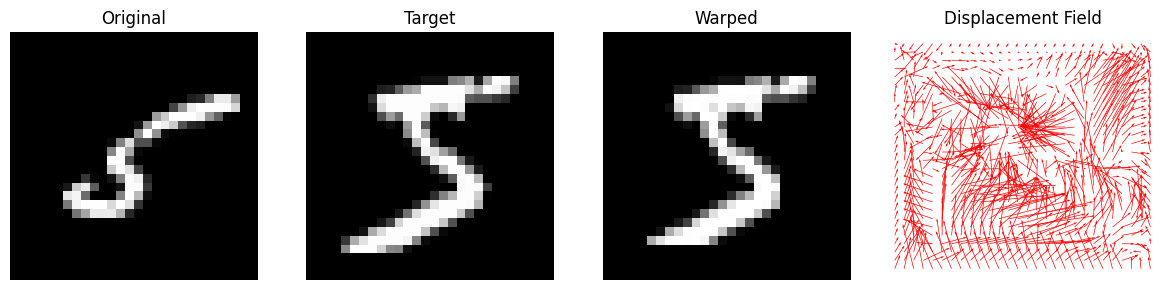

In [34]:
# Visualize the original, target, and aligned images
def visualize_single_alignment(original, target, transformed, displacement):
    plt.figure(figsize=(12, 3))
    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(original[0][0].cpu().numpy(), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    # Target image
    plt.subplot(1, 4, 2)
    plt.imshow(target[0][0].cpu().numpy(), cmap='gray')
    plt.title('Target')
    plt.axis('off')
    # Warped image
    plt.subplot(1, 4, 3)
    plt.imshow(transformed[0][0].detach().cpu().numpy(), cmap='gray')
    plt.title('Warped')
    plt.axis('off')
    # Displacement Field
    plt.subplot(1, 4, 4)
    disp = displacement[0].detach().cpu().numpy()
    dx = disp[:, :, 0]
    dy = disp[:, :, 1]
    H, W = dx.shape
    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(x, y)
    plt.quiver(X, Y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r')
    plt.title('Displacement Field')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate visualization
model.eval()
with torch.no_grad():
    transformed_image, displacement = model(image_to_align)
visualize_single_alignment(image_to_align, reference_image, transformed_image, displacement)

